In [1]:
!pip install qdrant_client langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.3/337.3 kB 6.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.2/471.2 kB 25.6 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.72
    Uninstalling langchain-core-0.3.72:
      Successfully uninstalled langchain-core-0.3.72
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.9
    Uninstalling langchain-text-splitters-0.3.9:
      Successfully uninstalled langchain-text-splitters-0.3.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.27 requires langchain-core<1.0.0,>=0.3.72, but you have langchain-

## setup

In [2]:
import numpy as np
import uuid
from tqdm.auto import tqdm
import json

In [3]:
import random, numpy as np, torch, os

SEED = 42  # choose any fixed number you like

# Python random
random.seed(SEED)

# NumPy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Make cudnn deterministic (slower but stable)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# For full reproducibility in SentenceTransformers
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["PYTHONHASHSEED"] = str(SEED)

#### overlap > 20% chunk size

In [4]:
CHUNK_SIZE = 1000
CHUNK_OVERLAP = 200
TOP_K = 5
TEMP = 0.75
SYSTEM_PROMPT = '''You are a really smart and educated expert in psychology. You are going to recieve a question about psychology, you must answer it correctly and precisely. Make sure that, the answer is full, concrete and answers the right question. Don't add the information that is irrelevant according to book's contents.'''

In [5]:
from datasets import load_dataset

def process_dataset(sample):
    sample['content'] = sample['content'].replace('\xa0', ' ')
    return sample

dataset = load_dataset("/kaggle/input/casml-generative-ai-hackathon/Dataset_RAG (1)")['train']
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['query_id', 'question'],
    num_rows: 50
})

In [6]:
dataset[0]

{'query_id': '1', 'question': 'What is the scientific method in psychology?'}

In [7]:
from transformers import pipeline
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'device - {device}')

generation_pipeline = pipeline(
    "text-generation",
    model="/kaggle/input/qwen2.5/transformers/1.5b-instruct/1",
    device=device,
    torch_dtype=torch.float16
)

2025-11-14 11:29:37.635551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763119777.843367      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763119777.903772      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

device - cuda


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

### experiment with system prompt

#### temperature lower for RAG, but try different.

## indexing

In [10]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("intfloat/multilingual-e5-large", model_kwargs={'torch_dtype': torch.float16})

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

### Qdrant database

In [12]:
from qdrant_client import QdrantClient, models

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="YASMI",
    on_disk_payload=True,
    vectors_config=models.VectorParams(
        size=1024,
        distance=models.Distance.COSINE,
        on_disk=True
    ),
    # fast retrieval (maybe try without it)
    #optimizer=models.OptimizerType.HNSW
)

True

### or FAISS (later Qdrant is used):

In [ ]:
import faiss
import numpy as np

index = faiss.IndexFlatIP(1024)  # Inner Product = cosine for normalized vectors
index.add(np.array(vectors, dtype=np.float32))

def semantic_search_faiss(query, limit=10):
    qv = embedding_model.encode(query, normalize_embeddings=True).astype(np.float32)
    D, I = index.search(np.expand_dims(qv, axis=0), limit)
    return [metadata_list[i] for i in I[0]]


### recursive chunking - baza (experiment with chunk size and overlap)

In [14]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from tqdm import tqdm

# Initialize text splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)

# Process PDF separately first
pdf_loader = PyPDFLoader("/kaggle/input/casml-generative-ai-hackathon/Dataset_RAG (1)/book.pdf")
pdf_documents = pdf_loader.load()

# Process PDF chunks
pdf_chunks = []
for i, doc in enumerate(tqdm(pdf_documents, desc="Processing PDF")):
    chunks = text_splitter.split_text(doc.page_content)
    for chunk in chunks:
        pdf_chunks.append({
            'content': chunk,
            'source': 'book.pdf',
            'page': doc.metadata.get('page_number', i + 1),
            'type': 'pdf'
        })

# Convert to your preferred format if needed
text_chunks_numbered = []
for idx, chunk in enumerate(pdf_chunks):
    text_chunks_numbered.append((idx, chunk['content'], chunk))

# Unpack
numbers, text_chunks, metadata_list = zip(*text_chunks_numbered)

Processing PDF: 100%|██████████| 753/753 [00:00<00:00, 18201.74it/s]


#### see the size of data in documents

Counting tokens:   0%|          | 0/2963 [00:00<?, ?it/s]

📘 Total number of chunks: 2963
🔢 Total tokens in all documents: 620,001
📊 Average tokens per chunk: 209.25
⚙️ Min tokens: 5, Max tokens: 364


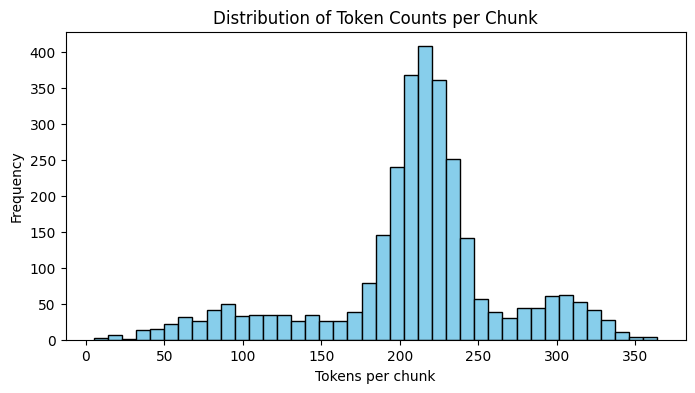

In [15]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("intfloat/multilingual-e5-large")

# text_chunks should be your list of chunks
token_counts = [len(tokenizer.encode(chunk)) for chunk in tqdm(text_chunks, desc="Counting tokens")]

print(f"📘 Total number of chunks: {len(text_chunks)}")
print(f"🔢 Total tokens in all documents: {sum(token_counts):,}")
print(f"📊 Average tokens per chunk: {np.mean(token_counts):.2f}")
print(f"⚙️ Min tokens: {np.min(token_counts)}, Max tokens: {np.max(token_counts)}")

plt.figure(figsize=(8,4))
plt.hist(token_counts, bins=40, color="skyblue", edgecolor="black")
plt.title("Distribution of Token Counts per Chunk")
plt.xlabel("Tokens per chunk")
plt.ylabel("Frequency")
plt.show()

### maybe try semantic chunking:

In [ ]:
from sentence_transformers import SentenceTransformer, CrossEncoder, util
from langchain_community.document_loaders import PyPDFLoader
from tqdm.notebook import tqdm
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

def semantic_chunk(text, threshold=0.5, max_chunk_size=CHUNK_SIZE):
    sentences = sent_tokenize(text)
    if len(sentences) == 0:
        return []

    embeddings = embedding_model.encode(sentences, convert_to_tensor=True, normalize_embeddings=True)
    chunks = []
    current_chunk = sentences[0]

    odd = False
    for i in range(1, len(sentences)):
        sim = util.cos_sim(embeddings[i - 1], embeddings[i]).item()
        if sim < threshold or len(current_chunk) > max_chunk_size:
            if sim < threshold:
                semantic_breaks += 1
            else:
                size_breaks += 1
            # alternate chunk ordering (your original logic)
            if odd:
                chunks.append(current_chunk.strip())
                odd = True
            else:
                chunks.reverse()
                chunks.append(current_chunk.strip())
                odd = False
            current_chunk = sentences[i]
        else:
            current_chunk += " " + sentences[i]

    chunks.append(current_chunk.strip())
    print('chunked semantically:', semantic_breaks)
    print('chunked by default:', size_breaks)
    return chunks

### try cross-encoder for reranking

In [ ]:
cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

# --- Cross-Encoder Reranking Example ---
# This part can be used later during retrieval to refine similarity ranking
def rerank_with_cross_encoder(query, passages, top_k=5):
    """
    Given a query and a list of passage dicts (each with 'text' or 'content'),
    returns the top_k highest-ranked passages.
    """
    # Extract plain text for scoring
    texts = [p["text"] if "text" in p else p["content"] for p in passages]

    # Form query-passage pairs for the cross-encoder
    pairs = [(query, text) for text in texts]

    # Get relevance scores
    scores = cross_encoder.predict(pairs)

    # Sort by score
    ranked_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)

    # Return the top_k *original* passage dicts
    return [passages[i] for i in ranked_indices[:top_k]]

In [ ]:
metadata_list[0]

In [16]:
vectors = embedding_model.encode(text_chunks, batch_size=32, device=device, normalize_embeddings=True, show_progress_bar=True).tolist()

Batches:   0%|          | 0/93 [00:00<?, ?it/s]

In [17]:
for i in tqdm(range(len(vectors))):
    client.upsert(
        collection_name='YASMI',
        points=[
            models.PointStruct(
                id=str(uuid.uuid4()),
                vector=vectors[i],
                payload={
                    'text': text_chunks[i],
                    'page': metadata_list[i]['page'],
                    'section': 'unknown' # isnt actually used 
                }
            )
        ]
    )

  0%|          | 0/2963 [00:00<?, ?it/s]

In [18]:
query = dataset[0]['question']
dataset[0]['question']

'What is the scientific method in psychology?'

In [19]:
query_vector = embedding_model.encode(query, normalize_embeddings=True, device=device).tolist()

In [20]:
hits = client.search(
    collection_name="YASMI",
    query_vector=query_vector,
    limit=TOP_K,
    # this if want to try KNN:
    # search_params=models.SearchParams(exact=True)
)

/tmp/ipykernel_48/3968438655.py:1: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = client.search(


In [21]:
[hit.payload for hit in hits]

[{'text': 'demographic shifts occurring in the United States and increased access to higher educational opportunities\namong historically underrepresented populations, there is reason to hope that the diversity of the field will\nincreasingly match the larger population, and that the research contributions made by the psychologists of the\nfuture will better serve people of all backgrounds (Women and Minorities in Psychology, n.d.).\nThe Process of Scientific Research\nScientific knowledge is advanced through a process known as the scientific method. Basically, ideas (in the\nform of theories and hypotheses) are tested against the real world (in the form of empirical observations), and\nthose empirical observations lead to more ideas that are tested against the real world, and so on. In this sense,\nthe scientific process is circular. The types of reasoning within the circle are called deductive and inductive. In',
  'page': 51,
  'section': 'unknown'},
 {'text': 'FIGURE 1.1 Psychology

## retrieval

### semantic search of relevant shunks

In [22]:
def semantic_search(client, query, limit=10):
    query_vector = embedding_model.encode(
        query, normalize_embeddings=True, device=device
    ).tolist()

    hits = client.search(
        collection_name="YASMI",
        query_vector=query_vector,
        limit=limit
    )
    relevant_chunks = [hit.payload for hit in hits]

    # if using cross encoder:
    #final_chunks = rerank_with_cross_encoder(query, relevant_chunks, top_k=5)

    return relevant_chunks

### or try BM25 search

In [ ]:
from rank_bm25 import BM25Okapi
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Tokenize your chunks
tokenized_corpus = [word_tokenize(chunk.lower()) for chunk in text_chunks]

# Build the BM25 index
bm25 = BM25Okapi(tokenized_corpus)


def bm25_search(query, limit=10):
    """
    BM25-based lexical retrieval
    """
    # Tokenize the query
    tokenized_query = word_tokenize(query.lower())

    # Compute BM25 scores for all chunks
    scores = bm25.get_scores(tokenized_query)

    # Get indices of top documents
    top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:limit]

    # Retrieve the top chunks + metadata
    relevant_chunks = [metadata_list[i] for i in top_indices]

    return relevant_chunks


### maybe combine 2 searches:

In [ ]:
def hybrid_search(query, alpha=0.5, limit=10):
    # BM25 search
    tokenized_query = word_tokenize(query.lower())
    bm25_scores = bm25.get_scores(tokenized_query)

    # Embedding-based search (via Qdrant)
    query_vector = embedding_model.encode(query, normalize_embeddings=True, device=device).tolist()
    hits = client.search(collection_name="YASMI", query_vector=query_vector, limit=limit)
    qdrant_scores = [hit.score for hit in hits]

    # Normalize & combine scores
    import numpy as np
    bm25_norm = (bm25_scores - np.min(bm25_scores)) / (np.ptp(bm25_scores) + 1e-8)
    qdrant_norm = (np.array(qdrant_scores) - np.min(qdrant_scores)) / (np.ptp(qdrant_scores) + 1e-8)
    hybrid_scores = alpha * bm25_norm + (1 - alpha) * qdrant_norm

    top_indices = np.argsort(hybrid_scores)[::-1][:limit]
    relevant_chunks = [metadata_list[i] for i in top_indices]

    return relevant_chunks


In [23]:
def llm_answer(query, context):
    prompt = f"""Information from the book:
{context}

Question:
{query}"""
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": prompt}, 
    ]
    output = generation_pipeline(messages, max_new_tokens=512, do_sample=True, temperature=TEMP, top_p=0.9)

    return output[0]['generated_text'][-1]['content'], context

### passing context and user query to LLM, making answer

In [24]:
def predict(query):
    selected_chunks = semantic_search(client, query)
    context = ' ; '.join([f"Book content piece: {chunk['text']}" for chunk in selected_chunks])
    pages = [chunk['page'] for chunk in selected_chunks]

    return (llm_answer(query, context), pages)

### building submission

In [25]:
import pandas as pd
# Load queries from your dataset
queries = dataset['question'].head(10)  # Adjust based on your dataset structure

# Generate answers
submission_data = []
for i, query in enumerate(queries):
    print(i, query)
    ans = predict(query)
    submission_data.append({
        'ID': i+1,
        'context': str(ans[0][1]),
        'answer': str(ans[0][0]),
        'references': json.dumps({"sections": ["section_1"], "pages": ans[1]})
    })

# Create and save submission
submission_df = pd.DataFrame(submission_data)
submission_df.to_csv('submission.csv', index=False)
print("Submission done!") 

/tmp/ipykernel_48/3970335436.py:6: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = client.search(


0 What is the scientific method in psychology?
1 What are the basic parts of a neuron?
2 What are the stages of sleep?
3 What is operant conditioning?
4 What is problem-solving in psychology?
5 What are the three stages of memory?
6 What are the key components of emotion?
7 What are the major personality traits in the Five Factor Model?


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


8 What is social psychology?
9 What is the sociocultural model in therapy?
10 What is the history of psychology?
11 Who were Wilhelm Wundt and William James?
12 What is functionalism in psychology?
13 What are Freud's contributions to psychology?
14 What are Gestalt principles?
15 What is classical conditioning?
16 What are Skinner's contributions to behaviorism?
17 What is Maslow's hierarchy of needs?
18 What is client-centered therapy?
19 What is cognitive psychology?
20 What is developmental psychology?
21 What is biopsychology?
22 What are evolutionary psychologists interested in?
23 What is sensation and perception?
24 What is the difference between sensation and perception?
25 What are Jean Piaget's theories of cognitive development?
26 What is object permanence?
27 What is the role of neurotransmitters in psychology?
28 What is the Big Five personality trait model?
29 What are psychological disorders?
30 What is the DSM-5?
31 What is the importance of ethics in psychological res

## try some query translation techniques:

In [7]:
from transformers import pipeline
import torch
import uuid
import numpy as np
from typing import List, Dict, Tuple
import re

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device - {device}')

# Initialize your existing pipeline
generation_pipeline = pipeline(
    "text-generation",
    model="/kaggle/input/qwen2.5/transformers/1.5b-instruct/1",
    device=device,
    torch_dtype=torch.float16
)

# Your existing Qdrant setup
from qdrant_client import QdrantClient, models

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="YASMI",
    on_disk_payload=True,
    vectors_config=models.VectorParams(
        size=1024,
        distance=models.Distance.COSINE,
        on_disk=True
    ),
)

# ===== RAG-FUSION & MULTI-QUERY IMPLEMENTATION =====

class AdvancedRAGSystem:
    def __init__(self, qdrant_client, generation_pipeline, embedding_model=None):
        self.client = qdrant_client
        self.generator = generation_pipeline
        self.embedding_model = embedding_model
        
    def generate_multiple_queries(self, original_query: str, num_queries: int = 3) -> List[str]:
        """Generate multiple related queries using the LLM"""
        prompt = f"""Based on the following question, generate {num_queries} different ways to ask this question or related questions that might help find relevant information. Be diverse and cover different aspects.

Original question: {original_query}

Generated questions:
1. {original_query}
2."""
        
        response = self.generator(
            prompt,
            max_new_tokens=100,
            num_return_sequences=1,
            do_sample=True,
            temperature=0.7
        )
        
        generated_text = response[0]['generated_text']
        # Extract the generated queries
        lines = generated_text.split('\n')
        queries = [original_query]  # Always include original
        
        for line in lines:
            if re.match(r'^\d+\.', line.strip()):
                query = re.sub(r'^\d+\.\s*', '', line.strip())
                if query and query != original_query:
                    queries.append(query)
        
        return queries[:num_queries]
    
    def reciprocal_rank_fusion(self, all_results: List[List[Dict]], k: int = 60) -> List[Dict]:
        """Combine results from multiple queries using Reciprocal Rank Fusion"""
        fused_scores = {}
        
        for query_results in all_results:
            for rank, result in enumerate(query_results):
                doc_id = result.payload['text']  # Using text as unique identifier
                if doc_id not in fused_scores:
                    fused_scores[doc_id] = 0
                fused_scores[doc_id] += 1 / (rank + k + 1)
        
        # Sort by fused score
        sorted_results = sorted(
            [{'payload': result[0].payload, 'score': score} 
             for score, result in zip(fused_scores.values(), all_results[0])],
            key=lambda x: x['score'],
            reverse=True
        )
        
        return sorted_results
    
    def rag_fusion_search(self, query: str, num_queries: int = 3, top_k: int = 5) -> List[Dict]:
        """Implement RAG-Fusion with multi-query generation"""
        # Step 1: Generate multiple queries
        queries = self.generate_multiple_queries(query, num_queries)
        print(f"Generated queries: {queries}")
        
        # Step 2: Search for each query (you'll need to implement embedding)
        all_results = []
        for q in queries:
            # This assumes you have a search function - you'll need to implement this
            # based on your embedding model
            results = self.semantic_search(q, top_k=top_k)
            all_results.append(results)
        
        # Step 3: Fuse results using RRF
        fused_results = self.reciprocal_rank_fusion(all_results)
        
        return fused_results[:top_k]
    
    def semantic_search(self, query: str, top_k: int = 5) -> List[Dict]:
        """Placeholder for semantic search - you'll need to implement this based on your embedding setup"""
        # You'll need to replace this with actual semantic search using your embeddings
        # For now, this is a placeholder that returns dummy results
        search_result = self.client.search(
            collection_name="YASMI",
            query_vector=self.get_embedding(query),  # You need to implement get_embedding
            limit=top_k
        )
        return search_result
    
    def get_embedding(self, text: str) -> List[float]:
        """Get embedding for text - you'll need to implement this based on your model"""
        # Placeholder - implement based on your embedding model
        # This should return a 1024-dimensional vector
        return np.random.random(1024).tolist()

# ===== STEP-BACK PROMPTING IMPLEMENTATION =====

def step_back_prompting(question: str, context: str) -> str:
    """Implement step-back prompting for better reasoning"""
    
    step_back_prompt = f"""Analyze the following question and provide fundamental concepts or principles that are needed to answer it. Think step by step about what background knowledge is required.

Question: {question}

First, identify the core concepts and principles:
1."""
    
    # Get step-back reasoning
    step_back_response = generation_pipeline(
        step_back_prompt,
        max_new_tokens=150,
        num_return_sequences=1,
        do_sample=False
    )
    
    step_back_text = step_back_response[0]['generated_text']
    
    # Now use the step-back reasoning to answer the original question
    final_prompt = f"""Based on the fundamental concepts and the provided context, answer the original question.

Fundamental Concepts:
{step_back_text}

Context:
{context}

Original Question: {question}

Answer:"""
    
    return final_prompt

# ===== INTEGRATED RAG SYSTEM =====

class IntegratedRAG:
    def __init__(self, qdrant_client, generation_pipeline):
        self.rag_system = AdvancedRAGSystem(qdrant_client, generation_pipeline)
        self.generator = generation_pipeline
    
    def query(self, question: str, use_rag_fusion: bool = True, use_step_back: bool = True) -> str:
        """Main query function that integrates all techniques"""
        
        # Step 1: Retrieve relevant context
        if use_rag_fusion:
            search_results = self.rag_system.rag_fusion_search(question)
        else:
            search_results = self.rag_system.semantic_search(question)
        
        # Combine retrieved contexts
        context = "\n\n".join([result['payload']['text'] for result in search_results])
        
        # Step 2: Apply step-back prompting if enabled
        if use_step_back:
            prompt = step_back_prompting(question, context)
        else:
            prompt = f"""Based on the following context, answer the question.

Context:
{context}

Question: {question}

Answer:"""
        
        # Step 3: Generate final answer
        response = self.generator(
            prompt,
            max_new_tokens=300,
            num_return_sequences=1,
            do_sample=False,
            temperature=0.3
        )
        
        return response[0]['generated_text']

# ===== USAGE EXAMPLE =====

# Initialize the integrated system
rag_system = IntegratedRAG(client, generation_pipeline)

# Example usage
def enhanced_rag_query(question: str):
    """Enhanced RAG query with all techniques"""
    print(f"Question: {question}")
    print("Processing with RAG-Fusion and Step-Back Prompting...")
    
    answer = rag_system.query(
        question, 
        use_rag_fusion=True, 
        use_step_back=True
    )
    
    print(f"Answer: {answer}")
    return answer

# Example usage
if __name__ == "__main__":
    # Test the enhanced system
    test_question = "What are Skinner's contributions to behaviorism?"
    enhanced_rag_query(test_question)

device - cuda


Device set to use cuda


Question: What are Skinner's contributions to behaviorism?
Processing with RAG-Fusion and Step-Back Prompting...


/tmp/ipykernel_48/1477266242.py:117: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = self.client.search(
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generated queries: ["What are Skinner's contributions to behaviorism?", 'How has B.F. Skinner influenced behaviorist theories?', "In what ways did B.F. Skinner's work contribute to the field of psychology?"]


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Answer: Based on the fundamental concepts and the provided context, answer the original question.

Fundamental Concepts:
Analyze the following question and provide fundamental concepts or principles that are needed to answer it. Think step by step about what background knowledge is required.

Question: What are Skinner's contributions to behaviorism?

First, identify the core concepts and principles:
1. Behaviorism
2. Operant conditioning
3. Reinforcement
4. Punishment

Next, consider how these concepts relate to each other in Skinner's work.
5. Classical conditioning (if applicable)
6. Observational learning (if applicable)

Finally, evaluate the significance of Skinner's contributions to understanding human behavior through his theories on operant conditioning and reinforcement schedules.

To analyze this question, we need to understand the foundational concepts of behaviorism, operant conditioning, and reinforcement. These concepts form the basis for Skinner's contributions to behav

In [5]:
!pip install qdrant_client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.3/337.3 kB 4.2 MB/s eta 0:00:00a 0:00:01
